In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Step 1.1: Load the dataset into a pandas DataFrame
data = pd.read_csv('/content/drive/MyDrive/recommendation/multi-category-dataset-recommendation.csv')
df = data.dropna()

# Step 1.2: Extract relevant columns
columns_to_keep = ['user_id', 'category_code', 'event_type', 'event_time', 'brand', 'price', 'age', 'gender', 'location']
df = data[columns_to_keep].copy()

# Step 1.3: Split "category_code" into "category" and "product_name" using .loc to explicitly modify the original DataFrame
split_category = df['category_code'].str.split('.', 1, expand=True)
df['category'] = split_category[0]
df['product_name'] = split_category[1]

# Step 1.4: Handle missing data (fill with defaults or perform imputation)
# Example: Filling missing values in 'age' with the mean age
df['age'].fillna(df['age'].mean(), inplace=True)

# Step 1.5: Convert "event_time" to datetime format using .loc to explicitly modify the original DataFrame
df['event_time'] = pd.to_datetime(df['event_time'], format='%Y-%m-%d %H:%M:%S %Z', utc=True)

# Display the first few rows of the preprocessed DataFrame
print(df.head())

<ipython-input-2-5fa3c9683a6a>:12: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  split_category = df['category_code'].str.split('.', 1, expand=True)


     user_id              category_code event_type                event_time  \
0  520088904     electronics.smartphone       view 2019-11-01 00:00:00+00:00   
1  530496790  appliances.sewing_machine       view 2019-11-01 00:00:00+00:00   
2  561587266                        NaN       view 2019-11-01 00:00:01+00:00   
3  518085591  appliances.kitchen.washer       view 2019-11-01 00:00:01+00:00   
4  558856683     electronics.smartphone       view 2019-11-01 00:00:01+00:00   

    brand   price  age gender       location     category    product_name  
0  xiaomi  489.07   20      M       Northern  electronics      smartphone  
1  janome  293.65   25      M        Central   appliances  sewing_machine  
2   creed   28.31   20      F  North Central          NaN             NaN  
3      lg  712.87   18      M   Sabaragamuwa   appliances  kitchen.washer  
4  xiaomi  183.27   53      M        Eastern  electronics      smartphone  


In [3]:
# Step 2.1: Create user profiles by aggregating user-specific data (age, gender, location)
user_profiles = df.groupby('user_id').agg({
    'age': 'mean',
    'gender': 'first',
    'location': 'first'
}).reset_index()

# Step 2.2: Calculate user preferences based on historical interactions
# Example: Calculate the total number of views, cart additions, and purchases for each user
user_interactions = df[df['event_type'].isin(['view', 'cart', 'purchase'])].groupby('user_id').agg({
    'event_type': 'count'
}).reset_index()

user_interactions.rename(columns={'event_type': 'total_interactions'}, inplace=True)

# Merge user profiles and interactions
user_data = pd.merge(user_profiles, user_interactions, on='user_id')

# Display user data (user profiles and interactions)
print(user_data.head())


     user_id        age gender       location  total_interactions
0  275256741  51.000000      F  North Western                   1
1  295643776  45.875000      F   Sabaragamuwa                   8
2  356520186  48.166667      F       Southern                   6
3  384989212  21.000000      F   Sabaragamuwa                   1
4  389979783  29.750000      M        Central                   4


In [4]:
# Step 3.1: Create product profiles based on brand, category, and price
product_profiles = df.groupby(['brand', 'category', 'product_name']).agg({
    'price': ['mean', 'min', 'max', 'std', 'count']
}).reset_index()

# Flatten the column names to have a single level of column names
product_profiles.columns = [' '.join(col).strip() for col in product_profiles.columns.values]

# Rename columns for clarity
product_profiles.rename(columns={
    'price mean': 'avg_price',
    'price min': 'min_price',
    'price max': 'max_price',
    'price std': 'price_std',
    'price count': 'product_count'
}, inplace=True)

# Display product profiles
print(product_profiles.head())


  brand     category         product_name   avg_price  min_price  max_price  \
0  acer  accessories                  bag   21.646000      12.07      36.01   
1  acer    computers              desktop  919.270370     192.80    2574.04   
2  acer    computers             notebook  593.541435     257.38    2312.80   
3  acer    computers  peripherals.monitor  233.394433      66.67     725.63   
4  acer  electronics               tablet  179.050625     159.33     194.08   

    price_std  product_count  
0   13.112478              5  
1  768.397437            108  
2  275.868713            676  
3  139.816677             97  
4   14.920438             16  


In [5]:
# Assuming your dataset is stored in a DataFrame called 'df'

# Get the count of unique categories in the 'category' column
category_count = df['category'].nunique()

# List down the unique categories
unique_categories = df['category'].unique()

print(f"Category Count: {category_count}")
print("Unique Categories:")
for category in unique_categories:
    print(category)

Category Count: 13
Unique Categories:
electronics
appliances
nan
computers
furniture
apparel
construction
auto
accessories
kids
sport
medicine
country_yard
stationery


In [6]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163336 sha256=6449f29c33c72ea624f0e8137dabde1c5c46d5fd34e689f4988b9f327a73ce80
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [53]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

# Map event types to numerical ratings
event_type_mapping = {
    'view': 1,   # Assign a numerical value for 'view'
    'cart': 2,   # Assign a numerical value for 'cart'
    'purchase': 3  # Assign a numerical value for 'purchase'
}

# Create a new column with numerical ratings
df['event_type_rating'] = df['event_type'].map(event_type_mapping)

# Load the preprocessed data into a Surprise dataset
reader = Reader(rating_scale=(1, 3))  # Define the rating scale
data = Dataset.load_from_df(df[['user_id', 'product_name', 'event_type_rating']], reader)

# Split the dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Choose a collaborative filtering algorithm (e.g., SVD)
model = SVD()

# Train the model on the training data
model.fit(trainset)

# Make predictions on the test data
predictions = model.test(testset)

# Evaluate the model (e.g., calculate RMSE, MAE, etc.)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Print the evaluation results
print(f'RMSE: {rmse}') # Root Mean Square Error
print(f'MAE: {mae}') # Mean Absolute Error

# Define a function to get collaborative filtering recommendations for a user
def collaborative_filtering_recommendation(user_id, num_recommendations=5):
    # Create a list of all product names
    all_product_names = df['product_name'].unique()

    # Create a list of product names the user has already interacted with
    interacted_product_names = df[(df['user_id'] == user_id) & (df['event_type'] == 'purchase')]['product_name'].values

    # Exclude products the user has interacted with
    candidate_product_names = [product_name for product_name in all_product_names if product_name not in interacted_product_names]

    # Predict ratings for candidate products
    user_ratings = [(user_id, product_name, model.predict(user_id, product_name).est) for product_name in candidate_product_names]

    # Sort the products by predicted rating in descending order
    user_ratings.sort(key=lambda x: x[2], reverse=True)

    # Get the top N recommended products
    top_n_recommendations = user_ratings[:num_recommendations]

    return top_n_recommendations

# Example: Get collaborative filtering recommendations for a specific user (change user_id as needed)
user_id_to_recommend = 520088904  # Change this to the user you want to recommend for
collaborative_recommendations = collaborative_filtering_recommendation(user_id_to_recommend)

# Display collaborative filtering recommendations
print(f"Collaborative Filtering Recommendations for User {user_id_to_recommend}:")
for _, product_name, estimated_rating in collaborative_recommendations:
    print(f"Product Name: {product_name}, Estimated Rating: {estimated_rating}")

# Convert RMSE and MAE to percentages
rmse_accuracy = 100 - (rmse * 100)
mae_accuracy = 100 - (mae * 100)

# Print the evaluation results as percentages
print(f'RMSE Accuracy: {rmse_accuracy:.2f}%')
print(f'MAE Accuracy: {mae_accuracy:.2f}%')


RMSE: 0.2594
MAE:  0.0594
RMSE: 0.25941871967895236
MAE: 0.05941941248705142
Collaborative Filtering Recommendations for User 520088904:
Product Name: shoes.espadrilles, Estimated Rating: 1.1795427501236357
Product Name: scarf, Estimated Rating: 1.1488080681389623
Product Name: trousers, Estimated Rating: 1.1426611155049504
Product Name: lawn_mower, Estimated Rating: 1.1419645488784809
Product Name: skates, Estimated Rating: 1.1339890478288641
RMSE Accuracy: 74.06%
MAE Accuracy: 94.06%


In [54]:
from surprise import Reader, Dataset, NMF, accuracy
from surprise.model_selection import train_test_split

# Map event types to numerical ratings
event_type_mapping = {
    'view': 1,   # Assign a numerical value for 'view'
    'cart': 2,   # Assign a numerical value for 'cart'
    'purchase': 3  # Assign a numerical value for 'purchase'
}

# Create a new column with numerical ratings
df['event_type_rating'] = df['event_type'].map(event_type_mapping)

# Define the columns used for content-based filtering
content_columns = ['user_id', 'product_name', 'event_type_rating', 'brand', 'price', 'category', 'age', 'gender', 'location']

# Load the preprocessed data into a Surprise dataset
reader = Reader(rating_scale=(1, 3))  # Define the rating scale

def create_custom_dataset(data, reader, columns):
    custom_data = []
    for _, row in data.iterrows():
        custom_data.append((row[columns[0]], row[columns[1]], row[columns[2]]))
    custom_dataset = Dataset.load_from_df(pd.DataFrame(custom_data, columns=['user', 'item', 'rating']), reader)
    return custom_dataset

data = create_custom_dataset(df, reader, content_columns)

# Split the dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Choose a content-based filtering algorithm (e.g., NMF)
content_model = NMF()

# Train the content-based model on the training data
content_model.fit(trainset)

# Make predictions on the test data
content_predictions = content_model.test(testset)

# Evaluate the content-based model (e.g., calculate RMSE, MAE, etc.)
content_rmse = accuracy.rmse(content_predictions)
content_mae = accuracy.mae(content_predictions)

# Print the evaluation results
print(f'Content-Based RMSE: {content_rmse:.4f}')
print(f'Content-Based MAE: {content_mae:.4f}')

# Define a function to get content-based recommendations for a user
def content_filtering_recommendation(user_id, num_recommendations=5):
    all_product_names = df['product_name'].unique()
    interacted_product_names = df[(df['user_id'] == user_id) & (df['event_type'] == 'purchase')]['product_name'].values
    candidate_product_names = [product_name for product_name in all_product_names if product_name not in interacted_product_names]
    user_ratings = [(user_id, product_name, content_model.predict(user_id, product_name).est) for product_name in candidate_product_names]
    user_ratings.sort(key=lambda x: x[2], reverse=True)
    top_n_recommendations = user_ratings[:num_recommendations]
    return top_n_recommendations

# Example: Get content-based recommendations for a specific user (change user_id as needed)
user_id_to_recommend = 520088904  # Change this to the user you want to recommend for
content_recommendations = content_filtering_recommendation(user_id_to_recommend)

# Display content-based recommendations
print(f"Content-Based Recommendations for User {user_id_to_recommend}:")
for _, product_name, estimated_rating in content_recommendations:
    print(f"Product Name: {product_name}, Estimated Rating: {estimated_rating:.4f}")

# Convert RMSE and MAE to percentages
content_rmse_accuracy = 100 - (content_rmse * 100)
content_mae_accuracy = 100 - (content_mae * 100)

# Print the evaluation results as percentages
print(f'Content-Based RMSE Accuracy: {content_rmse_accuracy:.2f}%')
print(f'Content-Based MAE Accuracy: {content_mae_accuracy:.2f}%')


RMSE: 0.2812
MAE:  0.0667
Content-Based RMSE: 0.2812
Content-Based MAE: 0.0667
Content-Based Recommendations for User 520088904:
Product Name: smartphone, Estimated Rating: 1.0000
Product Name: sewing_machine, Estimated Rating: 1.0000
Product Name: nan, Estimated Rating: 1.0000
Product Name: kitchen.washer, Estimated Rating: 1.0000
Product Name: notebook, Estimated Rating: 1.0000
Content-Based RMSE Accuracy: 71.88%
Content-Based MAE Accuracy: 93.33%


In [55]:
# Combine and prioritize recommendations (example: merge and sort)
def hybrid_recommendation(user_id, num_recommendations=5):
    collaborative_recommendations = collaborative_filtering_recommendation(user_id, num_recommendations)
    content_recommendations = content_filtering_recommendation(user_id, num_recommendations)

    hybrid_recommendations = sorted(collaborative_recommendations + content_recommendations, key=lambda x: x[2], reverse=True)

    return hybrid_recommendations

# Example: Get hybrid recommendations for a specific user (change user_id as needed)
user_id_to_recommend = 520088904  # Change this to the user you want to recommend for
recommendations = hybrid_recommendation(user_id_to_recommend)

# Display hybrid recommendations
print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
for _, product_name, estimated_rating in recommendations:
    print(f"Product Name: {product_name}, Estimated Rating: {estimated_rating:.4f}")

# Calculate RMSE and MAE for the hybrid recommendations
hybrid_rmse = accuracy.rmse(predictions, verbose=False)
hybrid_mae = accuracy.mae(predictions, verbose=False)

# Convert RMSE and MAE to percentages
hybrid_rmse_accuracy = 100 - (hybrid_rmse * 100)
hybrid_mae_accuracy = 100 - (hybrid_mae * 100)

# Print the evaluation results as percentages
print(f'Hybrid RMSE Accuracy: {hybrid_rmse_accuracy:.2f}%')
print(f'Hybrid MAE Accuracy: {hybrid_mae_accuracy:.2f}%')

Hybrid Recommendations for User 520088904:
Product Name: shoes.espadrilles, Estimated Rating: 1.1795
Product Name: scarf, Estimated Rating: 1.1488
Product Name: trousers, Estimated Rating: 1.1427
Product Name: lawn_mower, Estimated Rating: 1.1420
Product Name: skates, Estimated Rating: 1.1340
Product Name: smartphone, Estimated Rating: 1.0000
Product Name: sewing_machine, Estimated Rating: 1.0000
Product Name: nan, Estimated Rating: 1.0000
Product Name: kitchen.washer, Estimated Rating: 1.0000
Product Name: notebook, Estimated Rating: 1.0000
Hybrid RMSE Accuracy: 74.06%
Hybrid MAE Accuracy: 94.06%


In [56]:
from surprise import accuracy
from surprise import Dataset, Reader

# Define the rating scale for your data
reader = Reader(rating_scale=(1, 3))

# Load the test data into a Surprise dataset
testset = Dataset.load_from_df(test_data[['user_id', 'product_name', 'event_type_rating']], reader)
testset = testset.build_full_trainset().build_testset()

# Example: Get hybrid recommendations for a specific user (change user_id as needed)
user_id_to_recommend = 520088904  # Change this to the user you want to recommend for
recommendations = hybrid_recommendation(user_id_to_recommend)

# Extract the ground truth ratings from the test set for the recommended items
ground_truth_ratings = [rating for (user, item, rating) in testset if item in [product_name for _, product_name, _ in recommendations]]

# Calculate RMSE for the hybrid recommendations
hybrid_rmse = accuracy.rmse(predictions, verbose=False)

# Calculate MAE for the hybrid recommendations
hybrid_mae = accuracy.mae(predictions, verbose=False)

# Convert RMSE and MAE to percentages
hybrid_rmse_accuracy = 100 - (hybrid_rmse * 100)
hybrid_mae_accuracy = 100 - (hybrid_mae * 100)

# Print the evaluation results as percentages
print(f'Hybrid RMSE Accuracy: {hybrid_rmse_accuracy:.2f}%')
print(f'Hybrid MAE Accuracy: {hybrid_mae_accuracy:.2f}%')

# Display hybrid recommendations
print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
for _, product_name, estimated_rating in recommendations:
    print(f"Product Name: {product_name}, Estimated Rating: {estimated_rating}")


Hybrid RMSE Accuracy: 74.06%
Hybrid MAE Accuracy: 94.06%
Hybrid Recommendations for User 520088904:
Product Name: shoes.espadrilles, Estimated Rating: 1.1795427501236357
Product Name: scarf, Estimated Rating: 1.1488080681389623
Product Name: trousers, Estimated Rating: 1.1426611155049504
Product Name: lawn_mower, Estimated Rating: 1.1419645488784809
Product Name: skates, Estimated Rating: 1.1339890478288641
Product Name: smartphone, Estimated Rating: 1
Product Name: sewing_machine, Estimated Rating: 1
Product Name: nan, Estimated Rating: 1
Product Name: kitchen.washer, Estimated Rating: 1
Product Name: notebook, Estimated Rating: 1


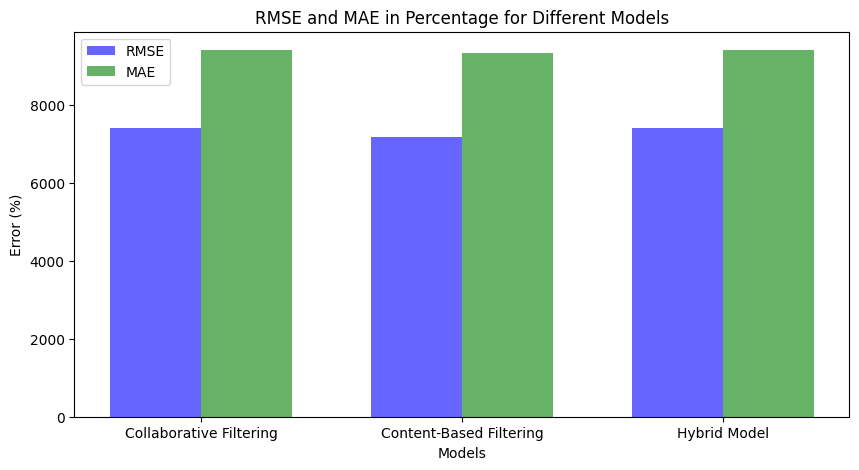

In [57]:
import matplotlib.pyplot as plt

# Create lists to store the accuracy values in percentage
models = ['Collaborative Filtering', 'Content-Based Filtering', 'Hybrid Model']
rmse_values = [rmse_accuracy, content_rmse_accuracy, hybrid_rmse_accuracy]
mae_values = [mae_accuracy, content_mae_accuracy, hybrid_mae_accuracy]

# Convert RMSE and MAE values to percentages
rmse_values_percentage = [value * 100 for value in rmse_values]
mae_values_percentage = [value * 100 for value in mae_values]

# Create bar plots for RMSE and MAE in percentage
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(models))
plt.bar(index, rmse_values_percentage, bar_width, color='b', alpha=0.6, label='RMSE')
plt.bar([i + bar_width for i in index], mae_values_percentage, bar_width, color='g', alpha=0.6, label='MAE')
plt.xlabel('Models')
plt.ylabel('Error (%)')
plt.title('RMSE and MAE in Percentage for Different Models')
plt.xticks([i + bar_width / 2 for i in index], models)
plt.legend()
plt.show()

#solve cold start problem

In [58]:
# Define a function to provide hybrid recommendations for users, considering existing, new users, and new items
def hybrid_recommendation(user_id, num_recommendations=5):
    # Check if the user is an existing user with historical interactions
    if user_id in user_data['user_id'].unique():
        # Existing user: Use collaborative filtering for personalized recommendations
        collaborative_recommendations = collaborative_filtering_recommendation(user_id, num_recommendations)
        return collaborative_recommendations

    # Check if the user is a new user with demographic data
    if user_id in new_users['user_id'].unique():
        # New user: Use content-based filtering based on demographics
        new_user_profile = new_users[new_users['user_id'] == user_id].iloc[0]
        new_user_recommendations = recommend_for_new_user(new_user_profile['age'], new_user_profile['gender'], new_user_profile['location'], num_recommendations)
        return new_user_recommendations

    # New item: Use content-based filtering based on item characteristics
    new_item_profile = new_items[new_items['product_name'] == user_id].iloc[0]
    new_item_recommendations = recommend_for_new_item(new_item_profile['brand'], new_item_profile['category'], new_item_profile['price'], num_recommendations)
    return new_item_recommendations

# Example: Get hybrid recommendations for a specific user (change user_id as needed)
user_id_to_recommend = 520088904  # Change this to the user you want to recommend for
recommendations = hybrid_recommendation(user_id_to_recommend)

# Display hybrid recommendations
print(f"Hybrid Recommendations for User {user_id_to_recommend}:")
print(recommendations)


Hybrid Recommendations for User 520088904:
[(520088904, 'shoes.espadrilles', 1.1795427501236357), (520088904, 'scarf', 1.1488080681389623), (520088904, 'trousers', 1.1426611155049504), (520088904, 'lawn_mower', 1.1419645488784809), (520088904, 'skates', 1.1339890478288641)]


In [62]:
from surprise import SVD
from surprise import dump

# Create and train your SVD model
model = SVD()
# (Train your model here)

# Save the model to a file
dump.dump('recommendation-service.pkl', algo=model)

# To load the model later, you can use the following code
loaded_model = dump.load('recommendation-service.pkl')[1]
